# Partial Exam GLM

@roman avj

11 March 2024

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pymc as pm
import arviz as az
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


---
# Q1: Argentina Mortgage Data

Let $\theta$ be the rate of mortgage loans granted by a bank in Argentina. During 2023 the average rate was 60% and the standard deviation of the rate was 0.04. So far in 2024, 100 loans have been requested, of which only 50 have been granted.



## Q1.A: Beta Prior

Using the information from last year, find the beta distribution that best describes the initial knowledge


In [2]:
# solve system of equations
from scipy.optimize import fsolve

# define the system of equations
def equations(vars, b1, b2):
    # unpack
    alpha, beta = vars

    # define the equations as the mean and variance of a beta
    eq1 = alpha / (alpha + beta) - b1
    eq2 = (alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1)) - b2
    return [eq1, eq2]

# initial guess
init_guess = [1, 1]

# solve
alpha0, beta0 = fsolve(equations, init_guess, args=(0.6, 0.04**2))

# print
print(f"alpha: {alpha0:.2f}, beta: {beta0:.2f}")


alpha: 89.40, beta: 59.60


In [3]:
# check if the solution is correct
mean0 = alpha0 / (alpha0 + beta0)
variance0 = (alpha0 * beta0) / ((alpha0 + beta0)**2 * (alpha0 + beta0 + 1))
print(f"mean: {mean0:.2f}, std dev: {np.sqrt(variance0):.4f}")

mean: 0.60, std dev: 0.0400


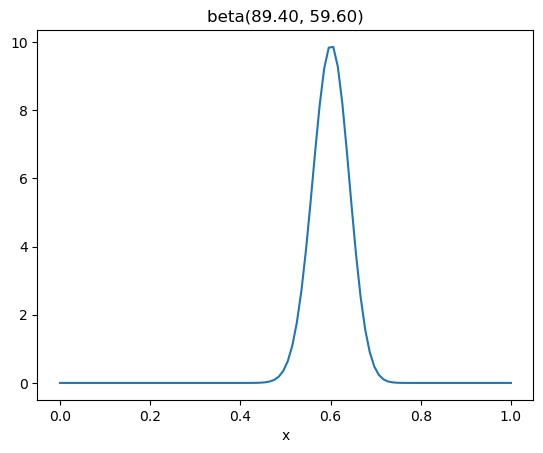

In [4]:
# plot the beta distribution
from scipy.stats import beta
x = np.linspace(0, 1, 100)
y = beta.pdf(x, float(alpha0), float(beta0))
plt.plot(x, y)
plt.title(f"beta({alpha0:.2f}, {beta0:.2f})")
plt.xlabel("x")
plt.show()

## Q1.B: Transformed Normal Distribution

Using the information from the previous year, find the transformed normal distribution that best describes the initial knowledge.


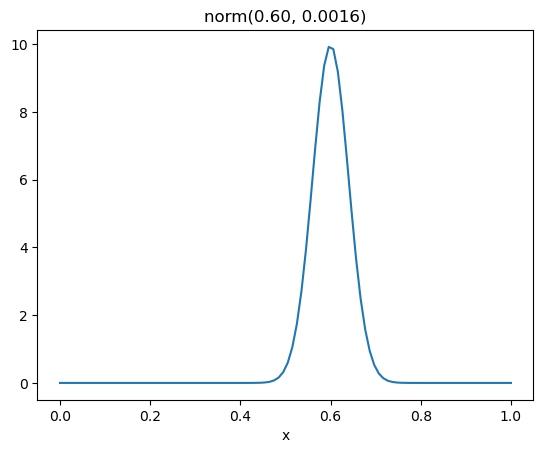

In [5]:
# we will suppose x ~ norm(0.6, 0.04**2)
from scipy.stats import norm

# params
mean0 = 0.6
variance0 = 0.04**2

# graph the normal distribution
x = np.linspace(0, 1, 100)
y = norm.pdf(x, loc=mean0, scale=np.sqrt(variance0))
plt.plot(x, y)
plt.title(f"norm({mean0:.2f}, {variance0:.4f})")
plt.xlabel("x")
plt.show()


## Q1.C: Initial Non-Informative Prior

Determine the inicial non-informative prior for the parameter $\theta$

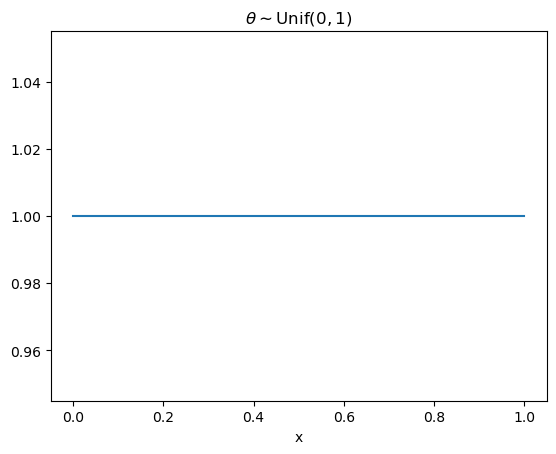

In [6]:
# we will assume \theta \propto 1 (but maybe is baised by jeffreys prior for beta distribution)
x = np.linspace(0, 1, 100)
y = np.repeat(1, 100)
plt.plot(x, y)
plt.title(r"$\theta \sim \text{Unif}(0,1)$")
plt.xlabel("x")
plt.show()

## Q1.D: Posterior of $\theta$ for 1.A, 1.B, 1.C

In [7]:
# 2005 params
n_obs = 100
n_success = 50

### 1.A model

In [9]:
# posterior distribution for 1.a
with pm.Model() as model1a:
    # prior
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    n = pm.ConstantData("n", n_obs)

    # likelihood
    y = pm.Binomial("y", n=n, p=theta, observed=n_success)

    # sample
    prior1a = pm.sample_prior_predictive(random_seed=42)
    trace1a = pm.sample(random_seed=42, cores=1)
    trace1a = pm.sample_posterior_predictive(
        trace1a, random_seed=42, extend_inferencedata=True
        )

Sampling: [theta, y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


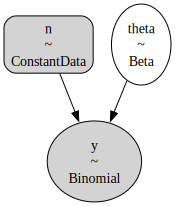

In [9]:
# graph model
pm.model_to_graphviz(model1a)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

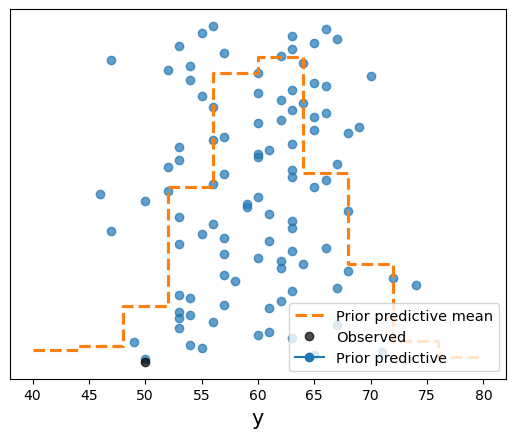

In [10]:
# prior predictive check
az.plot_ppc(prior1a, kind="scatter", data_pairs={"theta": "theta"}, group='prior', num_pp_samples=100)

prior predictuve makes sense with the beta distribution and observed data

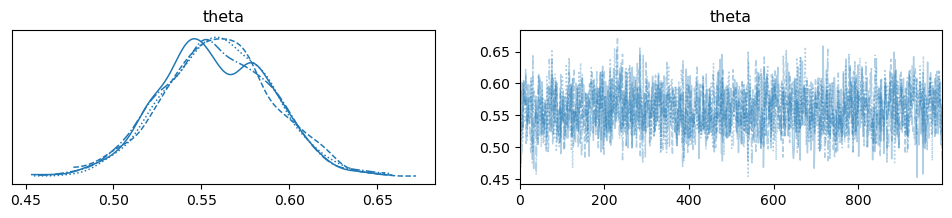

In [11]:
# posterior predictive check
az.plot_trace(trace1a)
plt.show()

In [12]:
# summary of the trace
az.summary(trace1a, hdi_prob=0.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.559  0.032   0.509    0.612      0.001    0.001    1655.0    2659.0   

       r_hat  
theta    1.0

The posterior distribution states that $\mathbb{E}[\theta]$ = 0.56 and $\sqrt{\text{Var}(\theta)}$ = 0.032, which distribution follows the above graph.

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

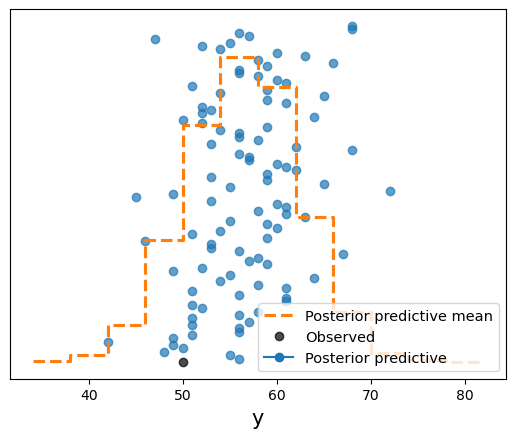

In [13]:
# posterior predictive
az.plot_ppc(
    trace1a,
    kind='scatter',
    data_pairs={"y": "y"},
    num_pp_samples=100
)

The above graph is the predictive posterior after the given information

### 1.B model

In [14]:
# posterior distribution for 1.b
with pm.Model() as model1b:
    # prior
    theta = pm.Normal("theta", mu=mean0, sigma=np.sqrt(variance0))
    n = pm.ConstantData("n", n_obs)

    # likelihood
    y = pm.Binomial("y", n=n, p=theta, observed=n_success)

    # sample
    prior1b = pm.sample_prior_predictive(random_seed=42)
    trace1b = pm.sample(random_seed=42)
    trace1b = pm.sample_posterior_predictive(
        trace1b, random_seed=42, extend_inferencedata=True
        )

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
Sampling: [y]


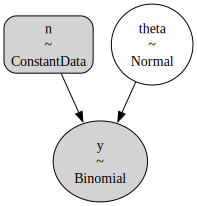

In [15]:
# graph model
pm.model_to_graphviz(model1b)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

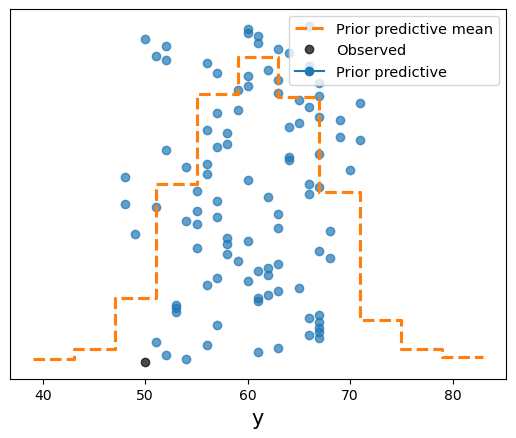

In [16]:
# prior predictive check
az.plot_ppc(prior1b, kind="scatter", data_pairs={"theta": "theta"}, group='prior', num_pp_samples=100)

prior predictuve makes sense with the Normal distribution and observed data

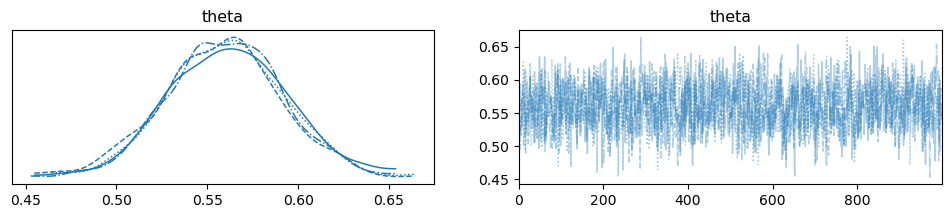

In [17]:
# posterior predictive check
az.plot_trace(trace1b)
plt.show()

In [18]:
# summary of the trace
az.summary(trace1b, hdi_prob=0.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.56  0.032   0.507    0.612      0.001    0.001    1475.0    2732.0   

       r_hat  
theta    1.0

The posterior distribution states that $\mathbb{E}[\theta]$ = 0.56 and $\sqrt{\text{Var}(\theta)}$ = 0.032, which distribution follows the above graph. This posterior distribution is slightly wider than the previous one (looking at the hdi of 5%).

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

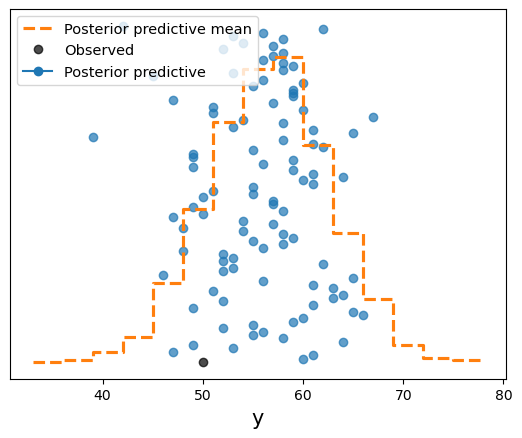

In [19]:
# posterior predictive
az.plot_ppc(
    trace1b,
    kind='scatter',
    data_pairs={"y": "y"},
    num_pp_samples=100
)

The above graph is the predictive posterior after the given information

### 1.C model

In [20]:
# posterior distribution for 1.a
with pm.Model() as model1c:
    # prior
    theta = pm.Uniform("theta", lower=0, upper=1)
    n = pm.ConstantData("n", n_obs)

    # likelihood
    y = pm.Binomial("y", n=n, p=theta, observed=n_success)

    # sample
    prior1c = pm.sample_prior_predictive(random_seed=42)
    trace1c = pm.sample(random_seed=42)
    trace1c = pm.sample_posterior_predictive(
        trace1c, random_seed=42, extend_inferencedata=True
        )

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Sampling: [y]


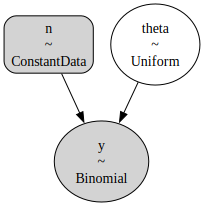

In [21]:
# graph model
pm.model_to_graphviz(model1c)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

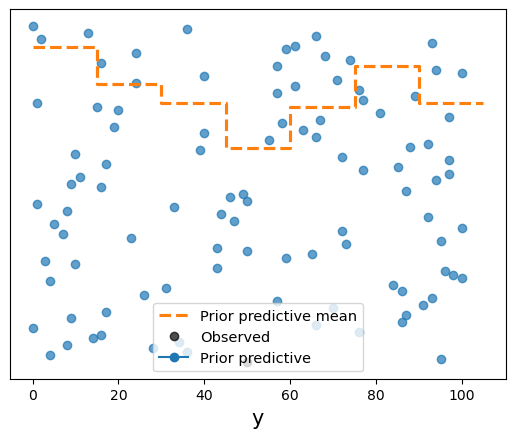

In [22]:
# prior predictive check
az.plot_ppc(prior1c, kind="scatter", data_pairs={"theta": "theta"}, group='prior', num_pp_samples=100)

prior predictuve makes sense with the uniform knownledge and observed data

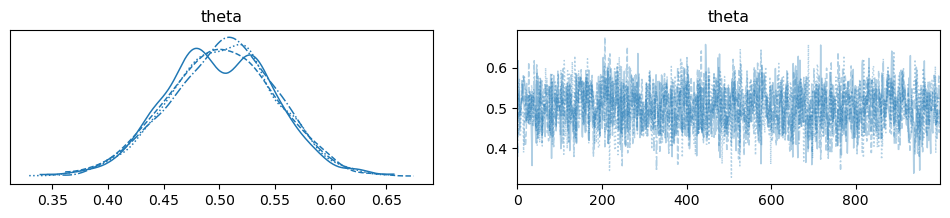

In [23]:
# posterior predictive check
az.plot_trace(trace1c)
plt.show()

In [24]:
# summary of the trace
az.summary(trace1c, hdi_prob=0.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.502  0.049   0.426    0.583      0.001    0.001    1607.0    2724.0   

       r_hat  
theta    1.0

The posterior distribution states that $\mathbb{E}[\theta]$ = 0.5 and $\sqrt{\text{Var}(\theta)}$ = 0.049, which distribution follows the above graph. This posterior distribution is has higher variance than the previous ones and the knowledge is the same as the observed data.

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

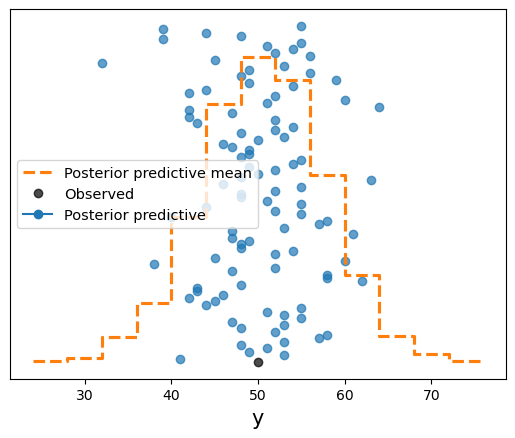

In [25]:
# posterior predictive
az.plot_ppc(
    trace1c,
    kind='scatter',
    data_pairs={"y": "y"},
    num_pp_samples=100
)

The above graph is the predictive posterior after the given information

## Q1.E: Estimate $\mathbb{E}[\theta]$ for 1.A, 1.B, 1.C

In the 1.D exercise we got that:
- The posterior rate for 1.a is $\mathbb{E}[\theta] = 0.559$ and $\text{std}(\theta) = 0.032$. 
- The posterior rate for 1.b is $\mathbb{E}[\theta] = 0.56$ and $\text{std}(\theta) = 0.032$.
- The posterior rate for 1.c is $\mathbb{E}[\theta] = 0.5$ and $\text{std}(\theta) = 0.049$.

## Q1.F: Estimate $\phi$ using the three different priors

Estimate the odds of giving a credit, i.e. $\phi = \frac{\theta}{1-\theta}$, using the three different priors

In [26]:
# 2005 params
n_obs = 100
n_success = 50

### 1.A model

In [27]:
# posterior distribution for 1.a
with pm.Model() as model1a:
    # prior
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    phi = pm.Deterministic("phi", theta / (1 - theta))
    n = pm.ConstantData("n", n_obs)

    # likelihood
    y = pm.Binomial("y", n=n, p=theta, observed=n_success)

    # sample
    prior1a = pm.sample_prior_predictive(random_seed=42)
    trace1a = pm.sample(random_seed=42)
    trace1a = pm.sample_posterior_predictive(
        trace1a, random_seed=42, extend_inferencedata=True
        )

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Sampling: [y]


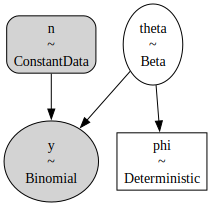

In [28]:
# graph model
pm.model_to_graphviz(model1a)

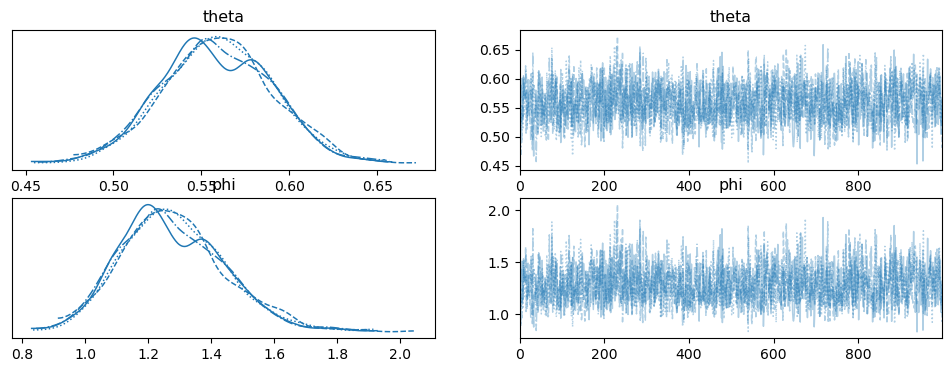

In [29]:
# posterior predictive check
az.plot_trace(trace1a)
plt.show()

In [30]:
# summary of the trace
az.summary(trace1a, hdi_prob=0.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.559  0.032   0.509    0.612      0.001    0.001    1655.0    2659.0   
phi    1.280  0.166   0.991    1.524      0.004    0.003    1655.0    2659.0   

       r_hat  
theta    1.0  
phi      1.0

The posterior distribution states that $\mathbb{E}[\phi]$ = 1.28, meaning that fo every 128 loans granted, 100 are not granted.

### 1.B model

In [31]:
# posterior distribution for 1.b
with pm.Model() as model1b:
    # prior
    theta = pm.Normal("theta", mu=mean0, sigma=np.sqrt(variance0))
    phi = pm.Deterministic("phi", theta / (1 - theta))
    n = pm.ConstantData("n", n_obs)

    # likelihood
    y = pm.Binomial("y", n=n, p=theta, observed=n_success)

    # sample
    prior1b = pm.sample_prior_predictive(random_seed=42)
    trace1b = pm.sample(random_seed=42)
    trace1b = pm.sample_posterior_predictive(
        trace1b, random_seed=42, extend_inferencedata=True
        )

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Sampling: [y]


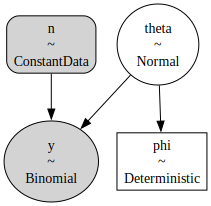

In [32]:
# graph model
pm.model_to_graphviz(model1b)

prior predictuve makes sense with the Normal distribution and observed data

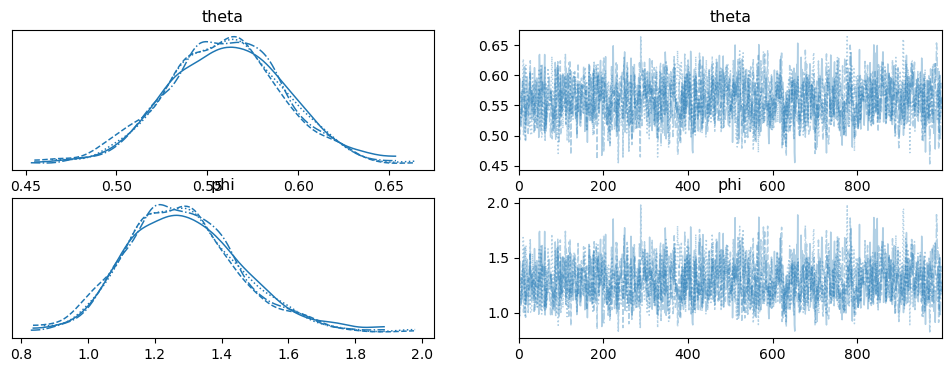

In [33]:
# posterior predictive check
az.plot_trace(trace1b)
plt.show()

In [34]:
# summary of the trace
az.summary(trace1b, hdi_prob=0.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.560  0.032   0.507    0.612      0.001    0.001    1475.0    2732.0   
phi    1.284  0.168   0.999    1.542      0.004    0.003    1475.0    2732.0   

       r_hat  
theta    1.0  
phi      1.0

The posterior distribution states that $\mathbb{E}[\phi]$ = 1.284, meaning that fo every 1284 loans granted, 1000 are not granted.

### 1.C model

In [35]:
# posterior distribution for 1.a
with pm.Model() as model1c:
    # prior
    theta = pm.Uniform("theta", lower=0, upper=1)
    phi = pm.Deterministic("phi", theta / (1 - theta))
    n = pm.ConstantData("n", n_obs)

    # likelihood
    y = pm.Binomial("y", n=n, p=theta, observed=n_success)

    # sample
    prior1c = pm.sample_prior_predictive(random_seed=42)
    trace1c = pm.sample(random_seed=42)
    trace1c = pm.sample_posterior_predictive(
        trace1c, random_seed=42, extend_inferencedata=True
        )

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Sampling: [y]


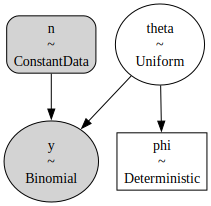

In [36]:
# graph model
pm.model_to_graphviz(model1c)

prior predictuve makes sense with the uniform knownledge and observed data

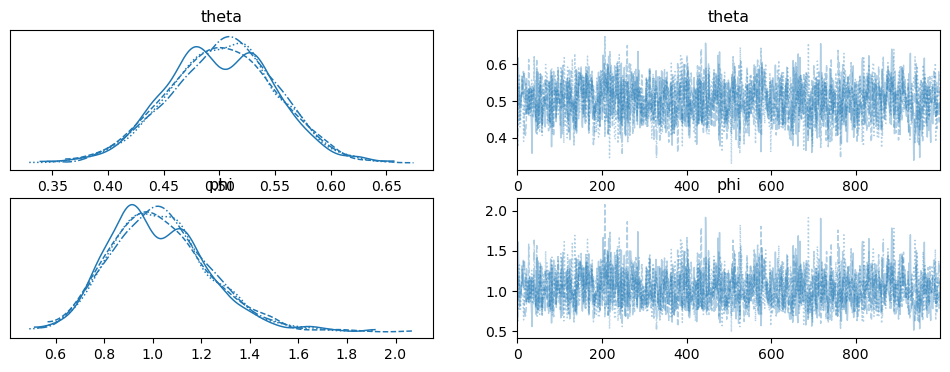

In [37]:
# posterior predictive check
az.plot_trace(trace1c)
plt.show()

In [38]:
# summary of the trace
az.summary(trace1c, hdi_prob=0.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
theta  0.502  0.049   0.426    0.583      0.001    0.001    1607.0    2724.0   
phi    1.028  0.204   0.692    1.342      0.005    0.004    1607.0    2724.0   

       r_hat  
theta    1.0  
phi      1.0

The posterior distribution states that $\mathbb{E}[\phi]$ = 1.028, meaning that fo every 1028 loans granted, 1000 are not granted.

# Q2: Company Utilities
The monthly utilities of a company have a distribution $\mathcal{N}(\mu, \sigma^{2})$ (here the variance is given, not the precision). Suppose that a sample of 10 months of this company resulted in the following utilities: (212, 207, 210, 196, 223, 193, 196, 210, 202, 221).


## Q2.A: Estimate $\mu$ and $\sigma^2$ 

The uncertainty about the average annual profit $\mu$ can be represented by a $\mathcal{N}(200, 40)$ distribution, and the uncertainty about the standard deviation of the monthly profits can be represented by a $G(10, 1)$ distribution. Estimate $\mu$ and $\sigma^2$ using the posterior distribution.

### Step 1: Data

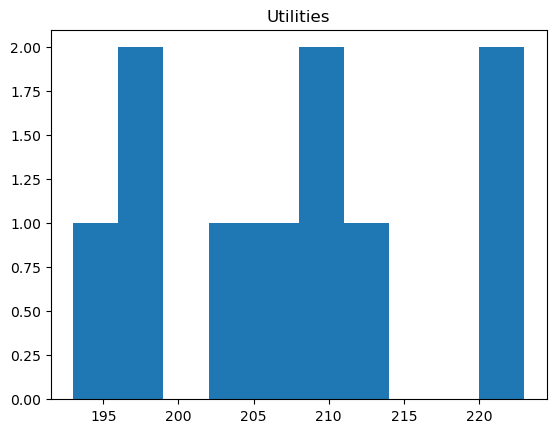

In [39]:
# data
data_utilities = np.array([212, 207, 210, 196, 223, 193, 196, 210, 202, 221])

# hist
plt.hist(data_utilities)
plt.title("Utilities")
plt.show()

### Step 2: Model

In [40]:
# model
with pm.Model() as model2a:
    # prior
    mu = pm.Normal("mu", mu=200, sigma=40)
    sigma = pm.Gamma("sigma", alpha=10, beta=1)

    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data_utilities)

    # sample
    prior2a = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace2a = pm.sample(2000, random_seed=42)
    trace2a = pm.sample_posterior_predictive(
        trace2a, random_seed=42, extend_inferencedata=True
        )

Sampling: [mu, sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
Sampling: [y]


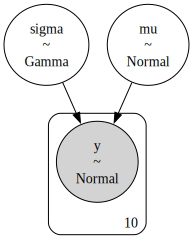

In [41]:
# look causal graph
pm.model_to_graphviz(model2a)

#### Prior predictive check

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

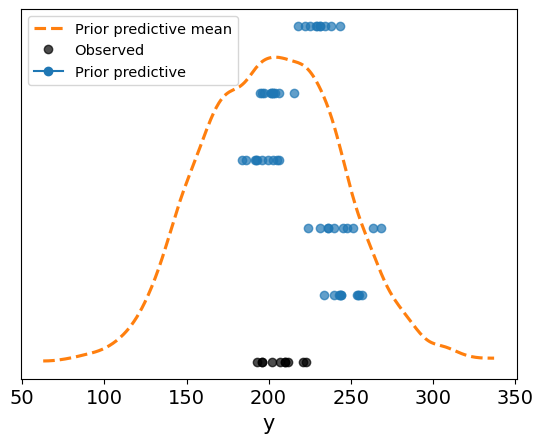

In [42]:
# plot ppc for prior
az.plot_ppc(prior2a, kind='scatter', group='prior', data_pairs={"y": "y"})

### Posterior predictive check

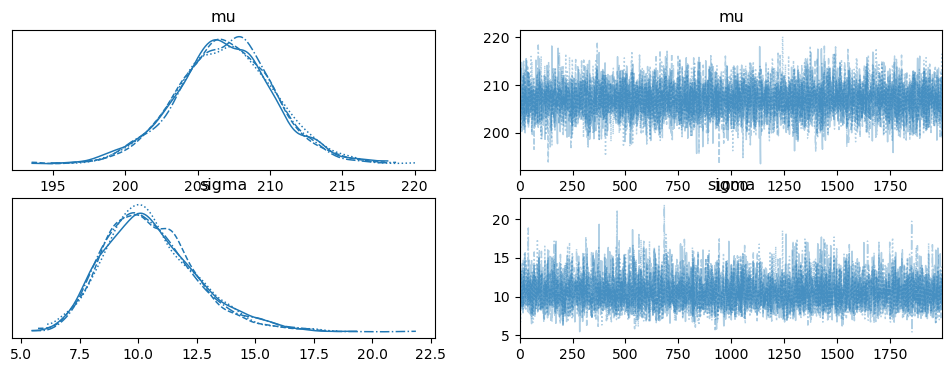

In [43]:
# posterior predictive check for coefficients
az.plot_trace(trace2a)
plt.show()

In [44]:
# Summary of the trace
az.summary(trace2a, hdi_prob=0.9)

mean     sd   hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
mu     206.922  3.390  200.986  212.265      0.042    0.029    6702.0   
sigma   10.541  1.984    7.383   13.699      0.026    0.018    5886.0   

       ess_tail  r_hat  
mu       5068.0    1.0  
sigma    4666.0    1.0

We can believe that $\mu=206.9$ and $\sigma=10.5$ with high probability.

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


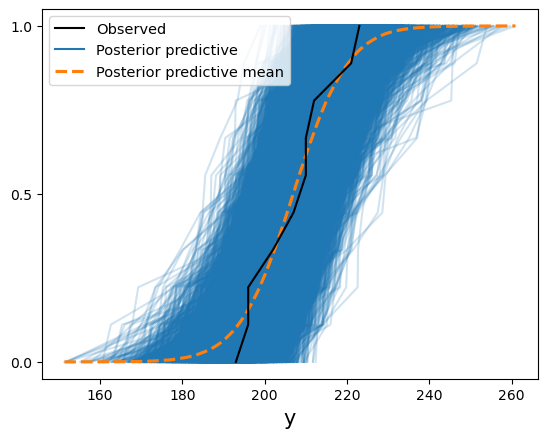

In [45]:
# posterior predictive for dependent variable
az.plot_ppc(
    trace2a,
    kind='cumulative',
    data_pairs={"y": "y"}
)

The posterior predictive check for the dependent variable looks well fitted.

## Q2.B: Non-informative prior

In [46]:
# model
with pm.Model() as model2_b:
    # prior
    mu = pm.Flat("mu")  # non-informative prior
    sigma = pm.Flat("sigma")  # non-informative prior (maybe here)

    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data_utilities)

    # sample
    trace2b = pm.sample(2000,random_seed=42)
    trace2b = pm.sample_posterior_predictive(
        trace2b, random_seed=42, extend_inferencedata=True
        )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


#### Posterior predictive check

It doesn't make sense to use a prior predictive check here, because the non-informative prior is not a distribution.

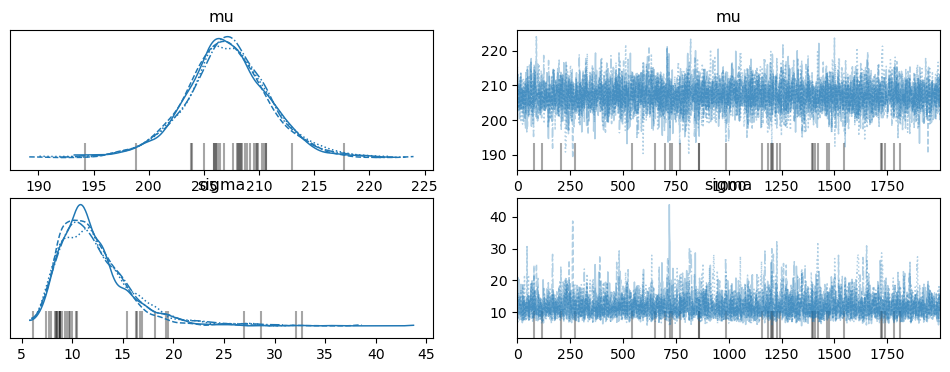

In [47]:
# posterior predictive check
az.plot_trace(trace2b)
plt.show()

In [48]:
# summary of the trace
az.summary(trace2b, hdi_prob=0.9)

mean     sd   hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
mu     207.07  3.950  200.857  213.717      0.059    0.041    4624.0   
sigma   12.15  3.561    6.997   16.858      0.073    0.055    3083.0   

       ess_tail  r_hat  
mu       4223.0    1.0  
sigma    2605.0    1.0

For non informative priors, the results are similar to the informative priors. We have that $\mu=207$ and $\sigma=12.15$. This is because the data is informative enough to estimate the parameters. The only difference is that the estimation of the parameters have higher uncertainty, specially for the disperssion.

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


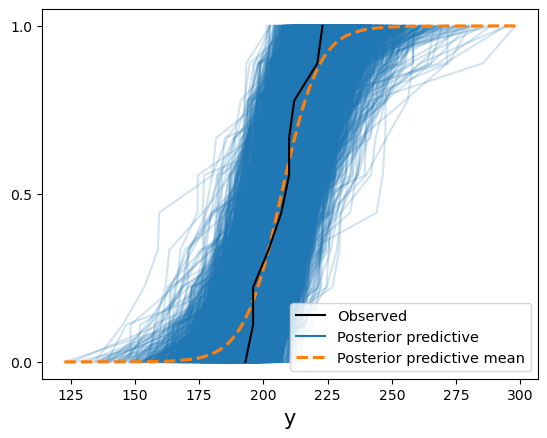

In [49]:
# posterior predictive for dependent variable
az.plot_ppc(
    trace2b,
    kind='cumulative',
    data_pairs={"y": "y"}
)

The posterior model looks sound, however it looks that their is more uncertainity in the posterior distribution of the dependent variable in comparisson with the previous model. Here the posterior can go from 125 up to 300, whereas in the previous model the posterior distribution was more concentrated around 200, where the posteriors went from 160 to 260. This is due to the non-informative priors used in this model which contain higher uncertainity.

# Q3: S&P Grades
Here contains the data of the S&P and Moody's ratings for 20 financial companies (calificaciones.txt). Do a complete Bayesian analysis of the data, adjusting a linear regression model, taking as the response variable the S&P ratings and as the explanatory variable the Moody's ratings.

Data is on `calificaciones.txt`.

### Step 1: Data

In [50]:
## Load Data from txt file with tab delimiter
# load data
df_sp_moodys = pd.read_csv("../data/calificaciones.txt", delimiter="\s+")
df_sp_moodys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP      20 non-null     float64
 1   MO      20 non-null     float64
dtypes: float64(2)
memory usage: 452.0 bytes


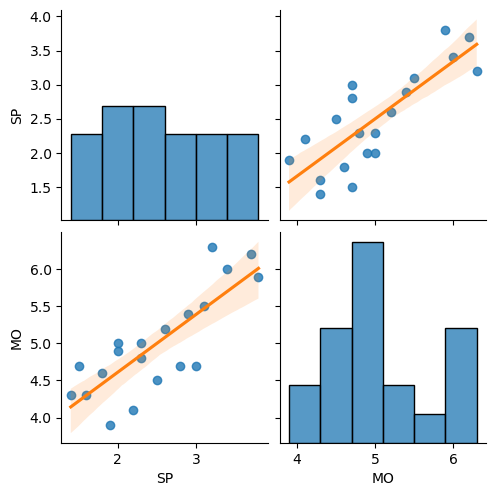

In [51]:
## Step 2: Look at the data 
sns.pairplot(df_sp_moodys, kind="reg", plot_kws={'line_kws':{'color':'C1'}})

In [52]:
# Look at the data
df_sp_moodys.describe()

SP        MO
count  20.000000  20.00000
mean    2.500000   5.00000
std     0.719649   0.69282
min     1.400000   3.90000
25%     1.975000   4.57500
50%     2.400000   4.85000
75%     3.025000   5.42500
max     3.800000   6.30000

Moodys has the following grades:
- Aaa
- Aa
- A
- Baa
- Ba
- B
- Caa
- Ca
- C

S&P has the following grades:
- AAA
- AA+
- AA
- AA-
- A+
- A
- A-
- BBB+
- BBB
- BBB-
- BB+
- BB
- BB-
- B+
- B
- B-
- CCC
- CC
- C

In comparisson, we can expect more dispersion in the S&P grades, as they have more categories. As well, in this exercise the grades are numerical, so we can't assert that the grades respect the order of the categories.

### Step 2: Bayesian Linear Regression

In [53]:
# Linear regression
with pm.Model(coords={"obs_id": df_sp_moodys.index}) as model3:
    # data
    x = pm.ConstantData("x", df_sp_moodys["MO"], dims="obs_id")

    # prior
    intercept = pm.Normal("intercept", mu=2.5, sigma=1)
    slope = pm.Normal("slope", mu=1, sigma=1)  # hypothesis of a 1:1 relationship
    sigma = pm.InverseGamma("sigma", alpha=1, beta=1)
    mu = pm.Deterministic("mu", intercept + slope * x, dims="obs_id")

    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=df_sp_moodys["SP"], dims="obs_id")

    # sample
    trace3 = pm.sample(2000, random_seed=42)
    trace3 = pm.sample_posterior_predictive(
        trace3, extend_inferencedata=True, random_seed=42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


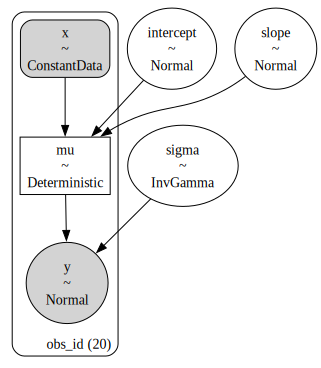

In [54]:
# look causal graph
pm.model_to_graphviz(model3)

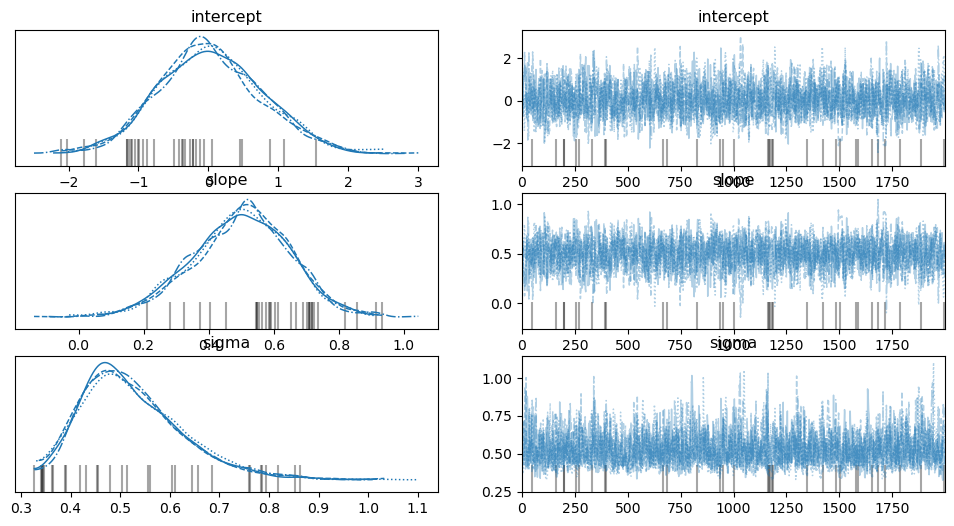

In [55]:
# posterior predictive check
az.plot_trace(trace3, var_names=["intercept", "slope", "sigma"])
plt.show()

In [56]:
# summary of the trace
az.summary(trace3,  var_names=["intercept", "slope", "sigma"], hdi_prob=0.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
intercept  0.038  0.752  -1.199    1.249      0.019    0.014    1515.0   
slope      0.499  0.150   0.253    0.738      0.004    0.003    1516.0   
sigma      0.527  0.106   0.363    0.685      0.003    0.002    1535.0   

           ess_tail  r_hat  
intercept    1468.0    1.0  
slope        1646.0    1.0  
sigma        1049.0    1.0

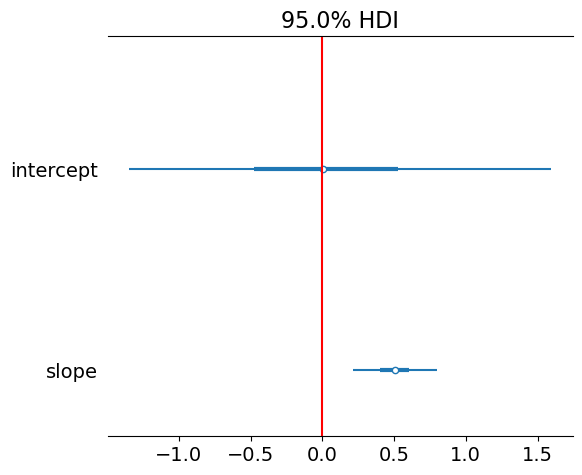

In [57]:
# Forest plot
az.plot_forest(trace3, var_names=["intercept", "slope"], combined=True, hdi_prob=0.95)

# draw vline at 0
plt.axvline(0, color='red')
plt.show()

array([<Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'slope'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

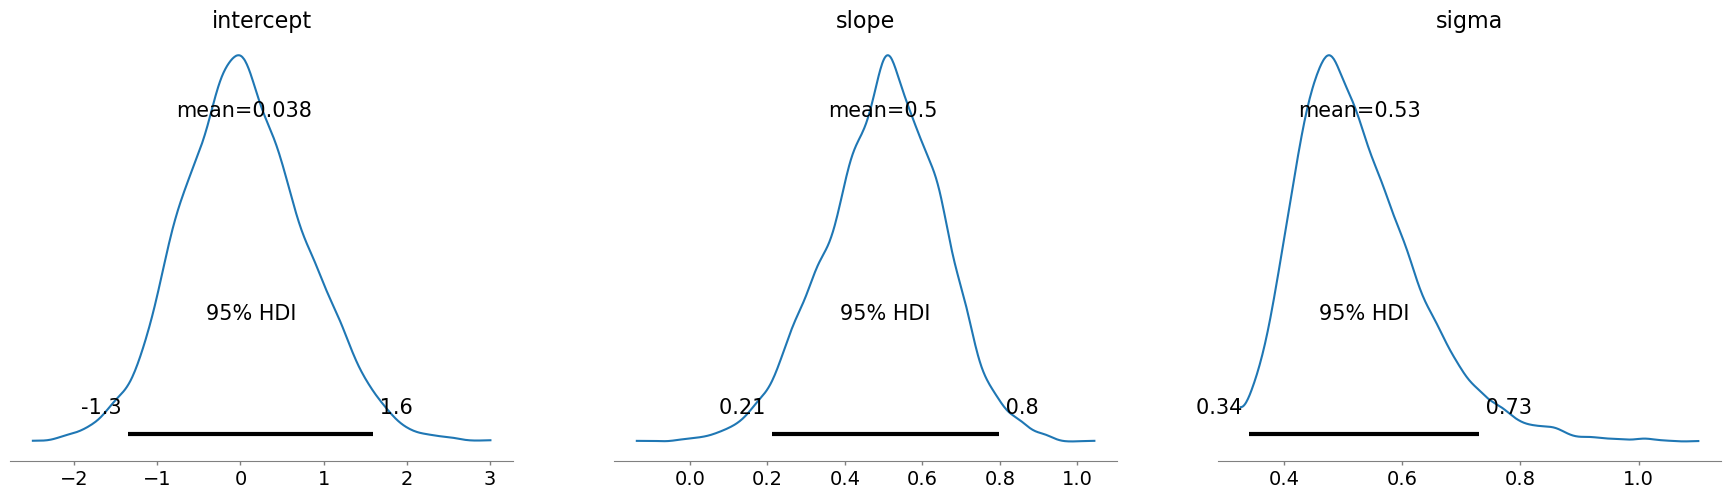

In [58]:
# plot posterior distribution for coefficients
az.plot_posterior(trace3, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


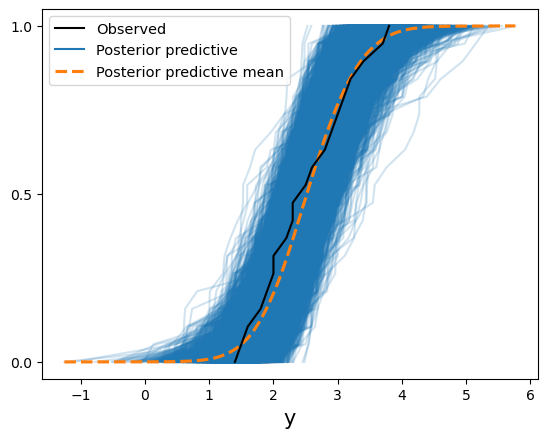

In [59]:
# posterior predictive
az.plot_ppc(
    trace3,
    kind='cumulative',
    data_pairs={"y": "y"}
)

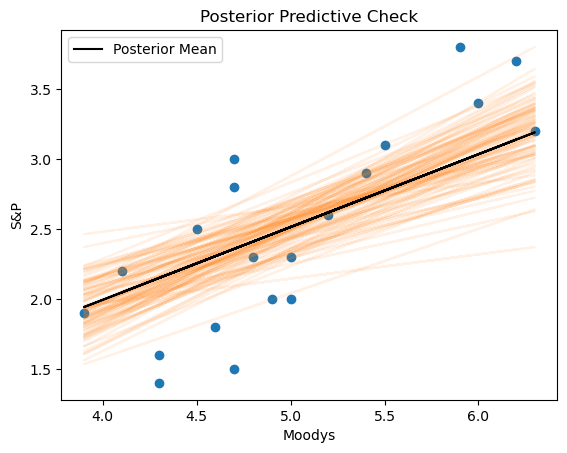

In [60]:
# Posterior predictive Linear Model
# show inference for each point
post = az.extract(trace3, num_samples=100)
x_plot = xr.DataArray(df_sp_moodys["MO"], dims=["obs_id"])
lines = post["intercept"] + post["slope"] * x_plot

# plot
plt.plot(df_sp_moodys["MO"], lines.transpose(), alpha=0.1, color='C1')
plt.plot(df_sp_moodys["MO"], lines.mean(dim="sample"), color='k', label="Posterior Mean")
plt.scatter(df_sp_moodys["MO"], df_sp_moodys["SP"])
plt.xlabel("Moodys")
plt.ylabel("S&P")
plt.legend()
plt.title("Posterior Predictive Check")
plt.show()


array([[<Axes: xlabel='obs_id', ylabel='y'>]], dtype=object)

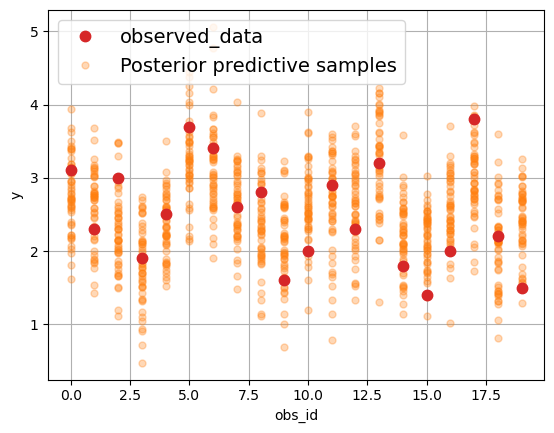

In [61]:
# Point estimate with posterior predictive for each observation
az.plot_lm(
    idata=trace3,
    y='y'
)

As we can see, the believe of the 1:1 data is not completely supported with the data, however it is highly probable that there exist the stated relationship. The posterior predictive check shows that the model is able to predict the data with a high degree of certainty. This is also supported by the posterior predictive check, where the model mean captures the data quite well.

# Q4: Anual Income
An investigator wishes to evaluate the relationship between the annual salary of mid- and high-level workers (Y, in thousands of dollars) and the quality of work index (X1), number of years of experience (X2), and the success index in publications (X3). The sample consists of 24 workers. Perform a complete Bayesian analysis of the data and obtain the salary predictions for 3 new employees with the following explanatory variables:

- $\underline{x}_{1F} = (5.4, 17, 6)'$
- $\underline{x}_{2F} = (6.2, 12, 5.8)'$
- $\underline{x}_{3F} = (6.4, 21, 6.1)'$

Data is on `salarios.txt`



### Step 1: Data

In [62]:
# Load Data from txt file with tab delimiter
# read data
df_salaries = pd.read_csv("../data/salarios.txt", delimiter="\s+")
df_salaries.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       24 non-null     float64
 1   X1      24 non-null     float64
 2   X2      24 non-null     float64
 3   X3      24 non-null     float64
dtypes: float64(4)
memory usage: 900.0 bytes


In [63]:
# summary of data
df_salaries.describe()

Y         X1         X2         X3
count  24.000000  24.000000  24.000000  24.000000
mean   39.500000   5.358333  24.958333   5.987500
std     5.474288   1.291415  11.222955   1.303611
min    30.100000   3.100000   5.000000   3.500000
25%    35.700000   4.425000  17.250000   5.000000
50%    38.850000   5.400000  25.000000   6.000000
75%    42.925000   6.275000  33.250000   7.000000
max    52.900000   8.000000  47.000000   8.300000

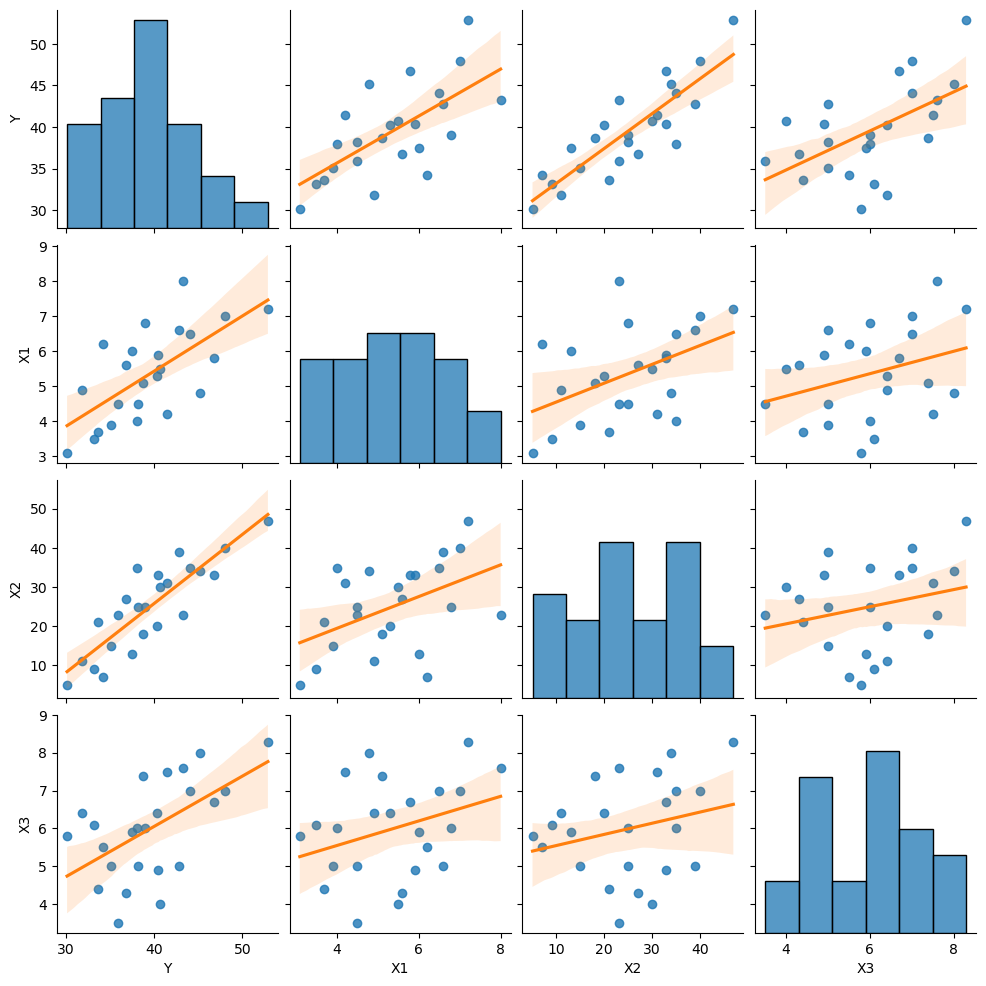

In [64]:
# matrix scatter plot, add lowess line
sns.pairplot(df_salaries, kind="reg", plot_kws={'line_kws': {'color': 'C1'}})
plt.show()

Focusing in the first row, we can see that the 3 variables (quality, experience, and success) are positively correlated with the salary. My prior insight is that each variables are similar in importance.

### Step 2: Bayessian Linear Regression

In [65]:
# GLM
with pm.Model(
    coords_mutable={"obs_id": df_salaries.index},
    coords={"predictor": df_salaries.filter(like='X').columns}
) as model4:
    # data
    x = pm.MutableData(
        "x",
        value=df_salaries.filter(like='X'),
        dims=["obs_id", "predictor"]
        )

    # prior
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    betas = pm.Normal("betas", mu=1, sigma=1, dims="predictor")
    sigma = pm.InverseGamma("sigma", alpha=1, beta=1)
    mu = pm.Deterministic("mu", intercept + pm.math.dot(x, betas), dims="obs_id")

    # likelihood
    y = pm.Normal(
        "y", mu=mu, sigma=sigma, 
        observed=df_salaries["Y"], dims="obs_id"
        )

    # sample
    trace4 = pm.sample(random_seed=42)
    trace4 = pm.sample_posterior_predictive(
        trace4, extend_inferencedata=True, random_seed=42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
Sampling: [y]


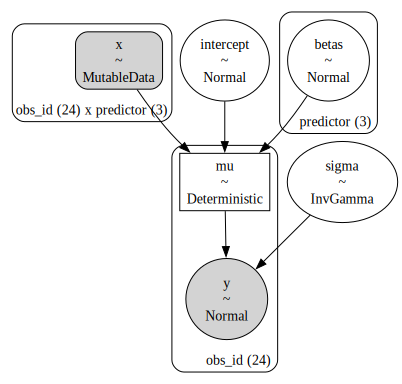

In [66]:
# Look causal graph
pm.model_to_graphviz(model4)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


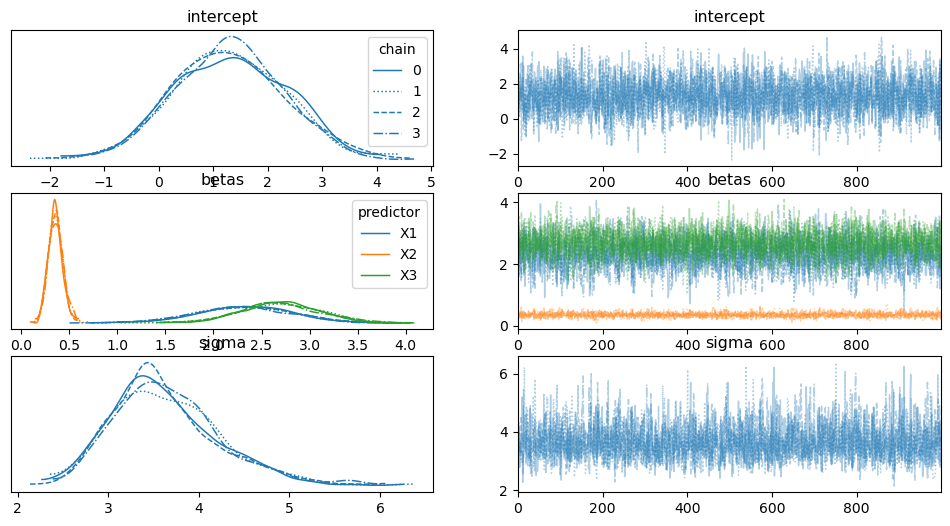

In [67]:
# Posterior predictive coefficients
az.plot_trace(trace4, var_names=["intercept", "betas", "sigma"], legend=True)
plt.show()

In [68]:
# Summary of the trace
az.summary(trace4, hdi_prob=0.9, var_names=["intercept", "betas", "sigma"])


mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
intercept  1.290  1.025  -0.341    2.970      0.018    0.014    3154.0   
betas[X1]  2.321  0.494   1.505    3.116      0.012    0.008    1805.0   
betas[X2]  0.359  0.075   0.235    0.479      0.001    0.001    2674.0   
betas[X3]  2.693  0.409   2.049    3.376      0.009    0.006    2203.0   
sigma      3.644  0.611   2.661    4.589      0.012    0.009    2489.0   

           ess_tail  r_hat  
intercept    2679.0    1.0  
betas[X1]    1939.0    1.0  
betas[X2]    2162.0    1.0  
betas[X3]    2459.0    1.0  
sigma        2384.0    1.0

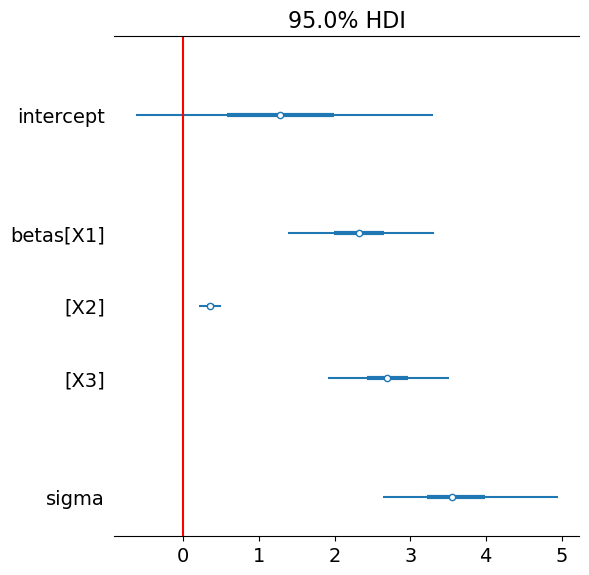

In [69]:
# Forest plot
az.plot_forest(trace4, combined=True, hdi_prob=0.95, var_names=["intercept", "betas", "sigma"])

# draw vline at 0
plt.axvline(0, color='red')
plt.show()

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'betas\nX1'}>,
        <Axes: title={'center': 'betas\nX2'}>],
       [<Axes: title={'center': 'betas\nX3'}>,
        <Axes: title={'center': 'sigma'}>, <Axes: >]], dtype=object)

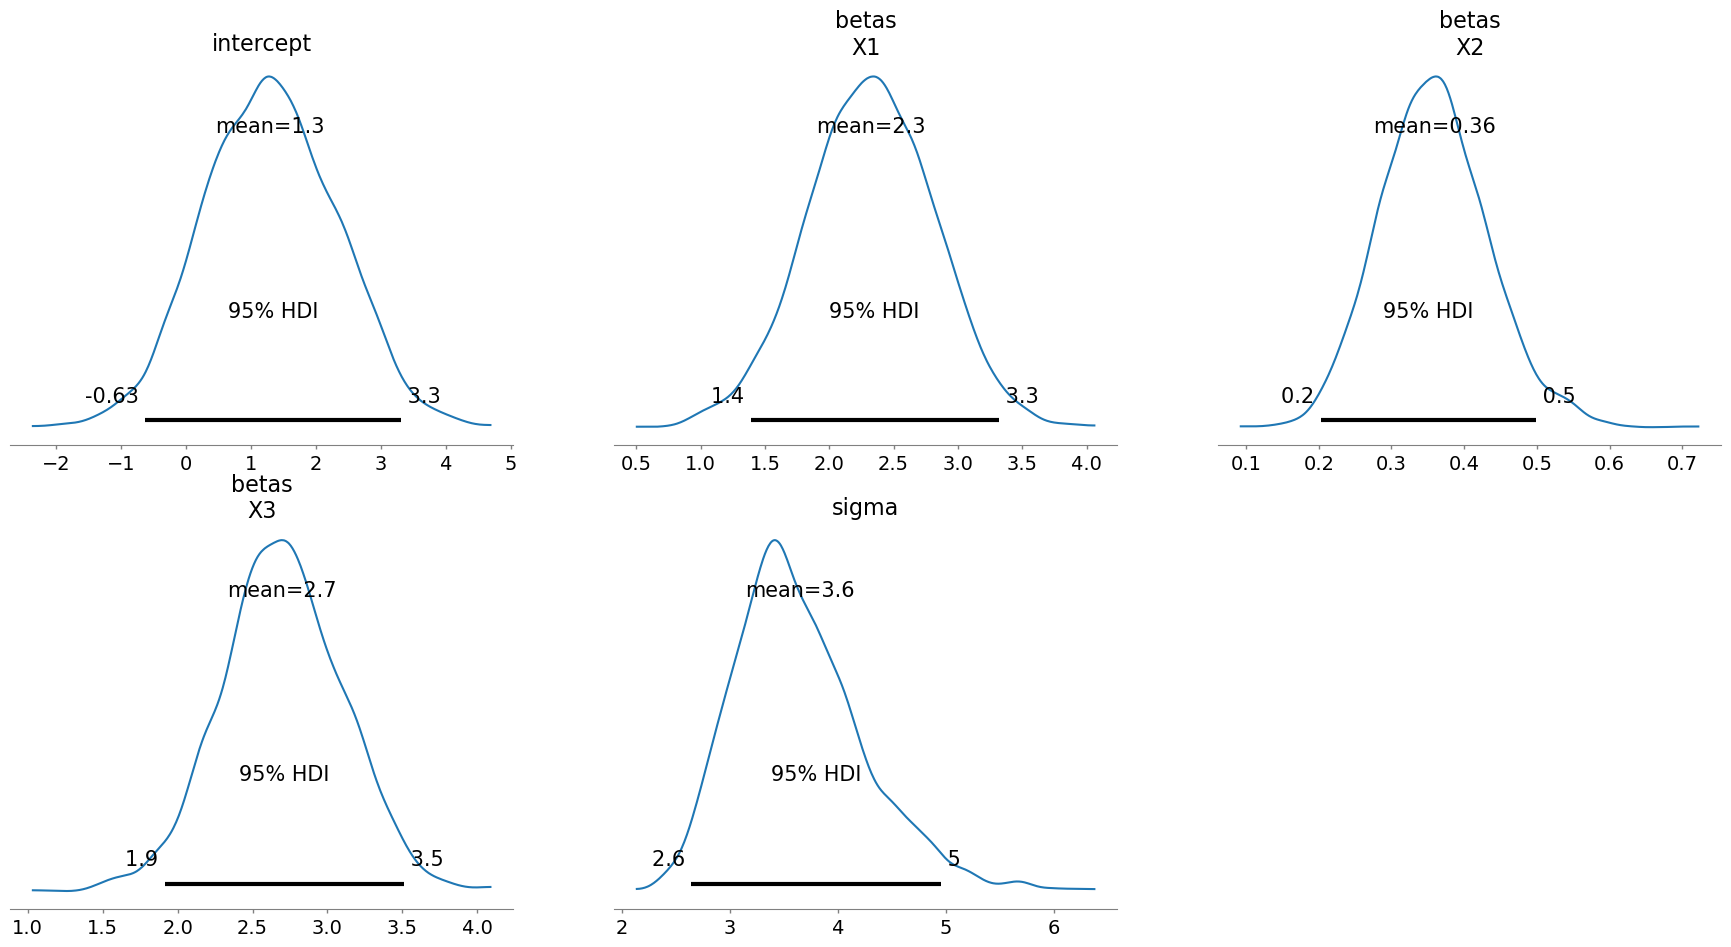

In [70]:
# Plot posterior coefficients distribution
az.plot_posterior(trace4, hdi_prob=0.95, var_names=["intercept", "betas", "sigma"])


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

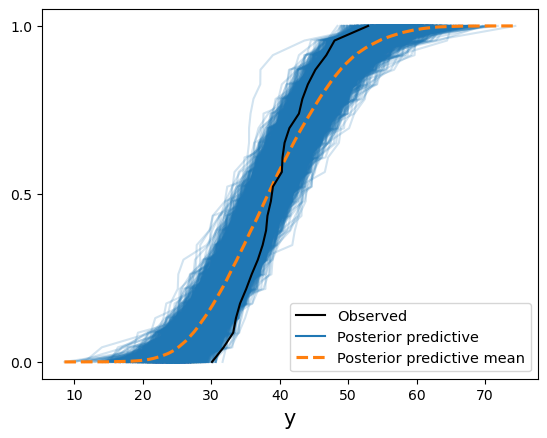

In [71]:
# posterior predictive check for the dependent variable
az.plot_ppc(
    trace4,
    kind='cumulative',
    data_pairs={"y": "y"}
)

array([[<Axes: xlabel='obs_id', ylabel='y'>]], dtype=object)

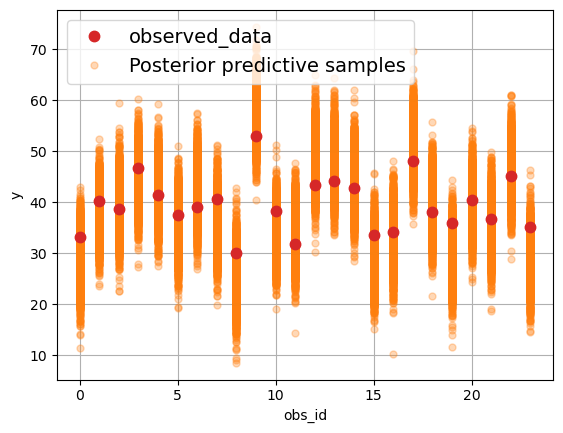

In [72]:
# posterior predictive point estimation for each point
az.plot_lm(
    idata=trace4,
    y='y',
    num_samples=4000,
    plot_dim="obs_id"
)

We can see that the model makes sound predictions for the dependent variable. The observed values are within the simulation of the data. However the predictions look with big variance, so we can't be sure of the predictions. As well, we saw at the beginning that the predictors are correlated, so we can't be sure of the importance of each variable.

### Step 3: Predictions

Predict the anual income for the following new employees:

- $\underline{x}_{1F} = (5.4, 17, 6)'$
- $\underline{x}_{2F} = (6.2, 12, 5.8)'$
- $\underline{x}_{3F} = (6.4, 21, 6.1)'$



To predict OOS points in pyMC, look [here](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html#types-of-data-containers).

In [73]:
# new data to predict
df_new_salaries = pd.DataFrame({
    "X1": [5.4, 6.2, 6.4],
    "X2": [17, 12, 21],
    "X3": [6, 5.8, 6.1],
})
df_new_salaries

X1  X2   X3
0  5.4  17  6.0
1  6.2  12  5.8
2  6.4  21  6.1

In [74]:
# create new data
with model4:
    # new data
    pm.set_data({"x": df_new_salaries}, coords={"obs_id": df_new_salaries.index})

    # sample
    posterior_pred = pm.sample_posterior_predictive(
        trace4,
        var_names=["y"],
        predictions=True,
        random_seed=42
    )

Sampling: [y]


In [75]:
posterior_pred.predictions["y"].mean(dim=["chain", "draw"]).values

array([36.1143748 , 35.59981881, 40.13887119])

array([<Axes: title={'center': 'y\n0'}>, <Axes: title={'center': 'y\n1'}>,
       <Axes: title={'center': 'y\n2'}>], dtype=object)

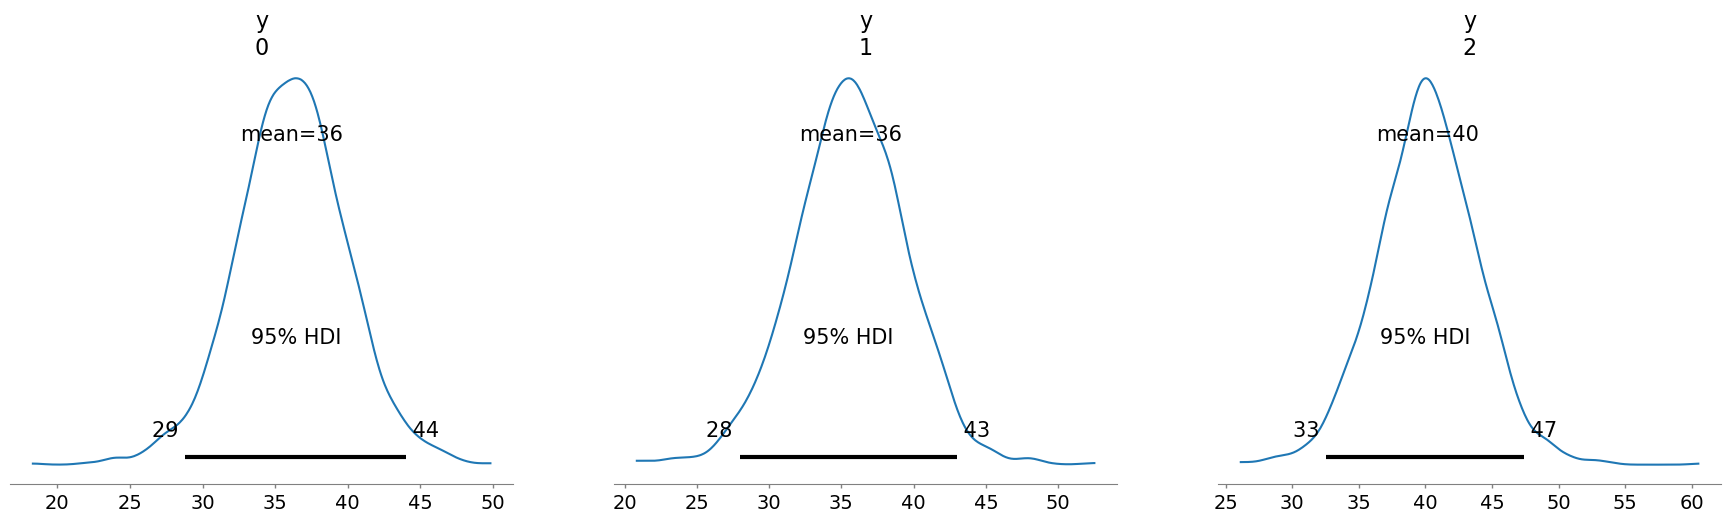

In [76]:
# plot the predictions
az.plot_posterior(posterior_pred, group="predictions", hdi_prob=0.95)

As expected, the worker number 3 with the highest variables $X_1$, $X_2$, and $X_3$ has the highest poredicted salary.

# Q5 Miners data
An insurance company wants to launch a new health insurance for miners. For this, it wants to estimate the probability of death $\pi$, based on the exposure time to the mineral ($X_i$ in hours). It has information on the deaths registered between 1950 and 1959, along with the exposure time to the mineral and the number of miners exposed. Perform a Bayesian analysis of the data and obtain the predictive distribution of the number of deaths assuming that there are 100 miners with an exposure time of 200 hours. The data is in the file `mortality.txt`.


## Q5.A: Logit Model

Suppose
$$
Y_{i}|\pi_{i} \sim \text{Binomial}(n_{i}, \pi_{i}), \\
\text{logit}(\pi_{i}) = \beta_{0} + \beta_{1}X_{i}
$$

with $\beta_{0} \sim \mathcal{N}(0, \tau=0.001)$ and $\beta_{1} \sim \mathcal{N}(0, \tau=0.001)$.

### Step 1: Data

In [77]:
# Read data
df_miners = pd.read_csv("../data/mortality.txt", delimiter="\s+")
df_miners

x   y    n
0    0  13  391
1    5   5  205
2   30   5  156
3   75   3   50
4  150   4   35
5  250  18   51

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_1046/778497083.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


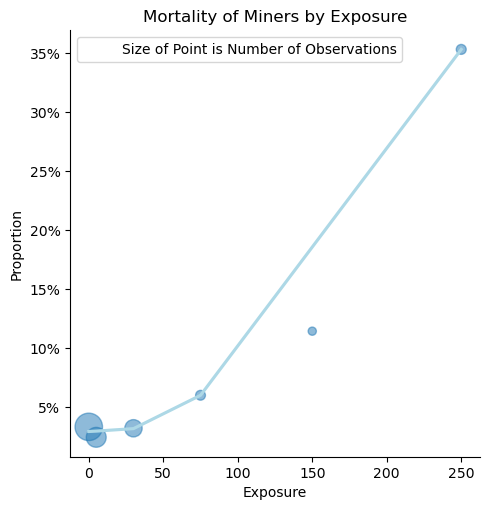

In [78]:
# Look at the data
df_miners = df_miners.assign(prop=lambda x: x["y"]/x["n"])

# plot regressor vs response
sns.lmplot(
    x="x",
    y="prop",
    data=df_miners,
    lowess=True,
    line_kws={"color": "lightblue"},
    scatter_kws={"color": "none"}
)

# size of the point by the number of observations
plt.scatter(
    df_miners["x"],
    df_miners["prop"],
    s=df_miners["n"],
    alpha=0.5
)


# add title
plt.title("Mortality of Miners by Exposure")
# add labels
plt.xlabel("Exposure")
plt.ylabel("Proportion")
# y label in percentage
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# add legend of the size
plt.legend(["Size of Point is Number of Observations"])
# show plot
plt.show()


Observing the data, it look that the proportion of deaths is higher for higher exposure, as intuitively expected.

### Step 2: Bayesian Logit Regression

In [79]:
# Model Logit Regression
with pm.Model(
    coords_mutable={"obs_id": df_miners.index}
) as model5a:
    # data
    x = pm.MutableData(
        "x",
        value=df_miners["x"],
        dims=["obs_id"]
    )
    n = pm.MutableData(
        "n",
        value=df_miners["n"],
        dims=["obs_id"]
    )

    # prior
    beta0 = pm.Normal("beta0", mu=0, tau=0.001)
    beta1 = pm.Normal("beta1", mu=0, tau=0.001)

    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="obs_id")  # link function

    # likelihood
    y = pm.Binomial("y", n=n, p=p, observed=df_miners["y"], dims="obs_id")

    # sample
    trace5a = pm.sample(random_seed=42)
    trace5a = pm.sample_posterior_predictive(
        trace5a, extend_inferencedata=True, random_seed=42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [y]


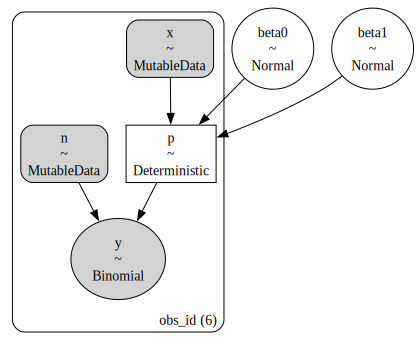

In [80]:
# look model
pm.model_to_graphviz(model5a)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


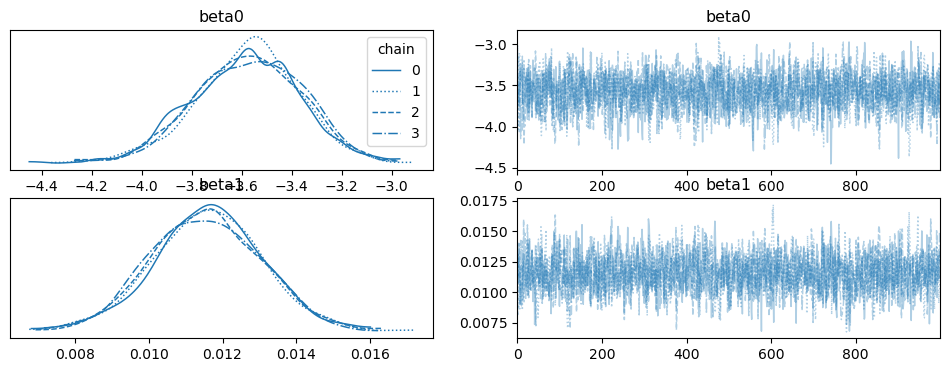

In [81]:
# posterior predictive check
az.plot_trace(trace5a, var_names=["beta0", "beta1"], legend=True)
plt.show()

In [82]:
# summary of the trace
az.summary(trace5a, hdi_prob=0.9, var_names=["beta0", "beta1"])

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0 -3.580  0.215  -3.943   -3.248      0.005    0.004    1694.0    2021.0   
beta1  0.012  0.002   0.009    0.014      0.000    0.000    1698.0    2121.0   

       r_hat  
beta0    1.0  
beta1    1.0

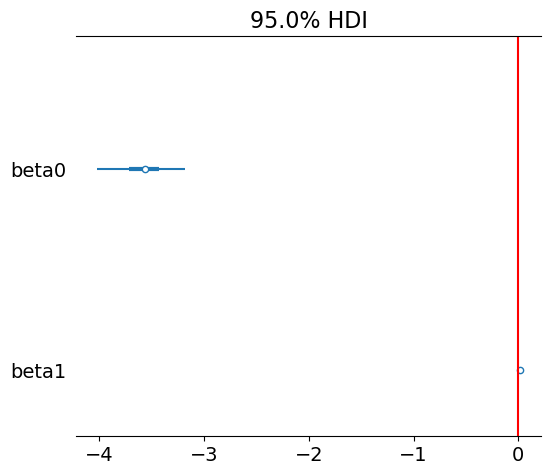

In [83]:
# forest plt
az.plot_forest(trace5a, combined=True, hdi_prob=0.95, var_names=["beta0", "beta1"])

# draw vline at 0
plt.axvline(0, color='red')
plt.show()

The posterior distribution for the parameters state that in general there is a low probability of sinning, and the probability of sinning increases with the exposure time but very slowly. The model states that for each minute of exposure the odds of sinning increases by 1.2%, in average.

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

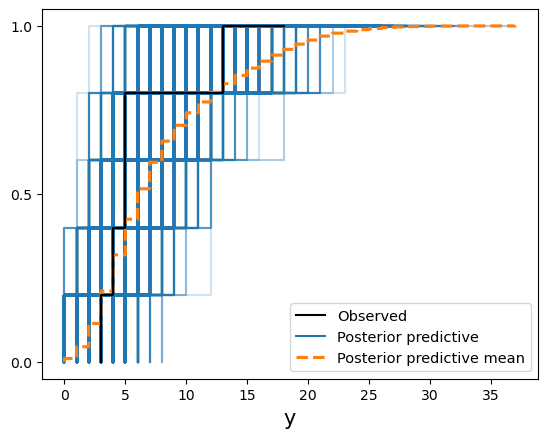

In [84]:
# Posterior predictive of the dependent variable
az.plot_ppc(
    trace5a,
    kind='cumulative',
    data_pairs={"y": "y"}
)

array([[<Axes: xlabel='x', ylabel='y'>]], dtype=object)

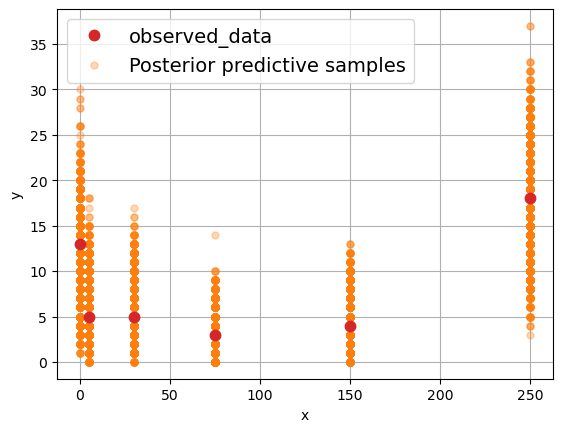

In [85]:
# point estimation with posterior predictive
az.plot_lm(
    idata=trace5a,
    y='y',
    x='x',
    num_samples=4000
)

Althought the model is able to predict the data, the predictions have high uncertainty. This is because the model is not able to capture the data well.

### Step 3: Out of Sample Prediction for $n=100$ miners with $X=200$ hours of exposure

In [86]:
# predict new data
with model5a:
    # new data
    pm.set_data({"x": pd.Series(200), "n": pd.Series(100)}, coords={"obs_id": [0]})

    # sample
    posterior_pred_5a = pm.sample_posterior_predictive(
        trace5a,
        var_names=["y"],
        predictions=True,
        random_seed=42
    )

Sampling: [y]


<Axes: title={'center': 'y\n0'}>

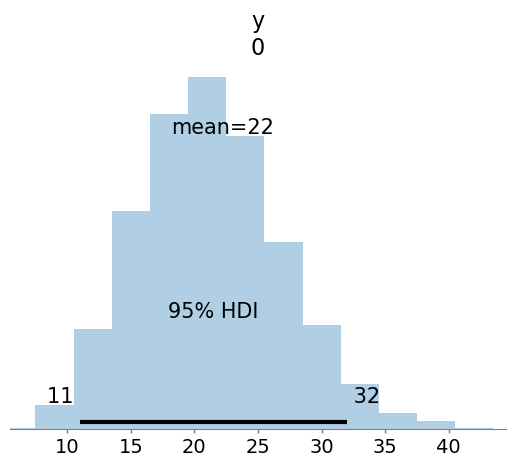

In [87]:
# plot the predictions
az.plot_posterior(posterior_pred_5a, group="predictions", hdi_prob=0.95)

The prediction of mortality for $N=100$ and $X=200$ is around 22 dead miners with a 95% credible interval of $[11, 32]$.

## Q5.B: Poisson Process for Coal Data

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 saved on `coal_data.txt`. The number of disasters is thought to have been affected by changes in safety regulations during this period.

Suppose
$$
Y_{t}|\mu_{t} \sim \text{Poisson}(\mu_{t}), \\
\log(\mu_{t}) = \beta_{0} + \beta_{1} t
$$

with $\beta_{0} \sim \mathcal{N}(0, \tau=0.001)$ and $\beta_{1} \sim \mathcal{N}(0, \tau=0.001)$. Using the `boot:coal` data from R. Perform a Bayesian analysis of the data.

### Step 1: Data

In [88]:
# Read data
df_coal = pd.read_csv("../data/coal_data.txt", delimiter="\s+")
df_coal

date
0    1851.202601
1    1851.632444
2    1851.969199
3    1851.974675
4    1852.314168
..           ...
186  1947.687201
187  1951.405202
188  1957.882957
189  1960.489391
190  1962.219713

[191 rows x 1 columns]

We observerd that the data is not aggregated, so we need to aggregate it by mine.

In [89]:
# Wrangle data
# date to integer and then group by year
df_coal["year"] = df_coal["date"].astype(int)
df_coal = df_coal.groupby("year").size()

# index a datetime
df_coal.index = pd.to_datetime(df_coal.index, format='%Y')
df_coal

year
1851-01-01    4
1852-01-01    5
1853-01-01    4
1854-01-01    1
1856-01-01    4
             ..
1947-01-01    4
1951-01-01    1
1957-01-01    1
1960-01-01    1
1962-01-01    1
Length: 79, dtype: int64

Also we can observed that there are some missing years, for example from 1947 to 1951. We will assume that the number of deaths is 0 for those years.

In [90]:
# Fill missing data with 0 mortality
# create index as datetime from 1851 to 1962
index = pd.date_range(start="1851", end="1962", freq="AS")

# create a new dataframe with the index
df_coal = pd.DataFrame(df_coal, index=index, columns=["y"])

# where is the missing data input 0
df_coal = df_coal.fillna(0)
df_coal

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_1046/116853085.py:3: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  index = pd.date_range(start="1851", end="1962", freq="AS")


y
1851-01-01  4.0
1852-01-01  5.0
1853-01-01  4.0
1854-01-01  1.0
1855-01-01  0.0
...         ...
1958-01-01  0.0
1959-01-01  0.0
1960-01-01  1.0
1961-01-01  0.0
1962-01-01  1.0

[112 rows x 1 columns]

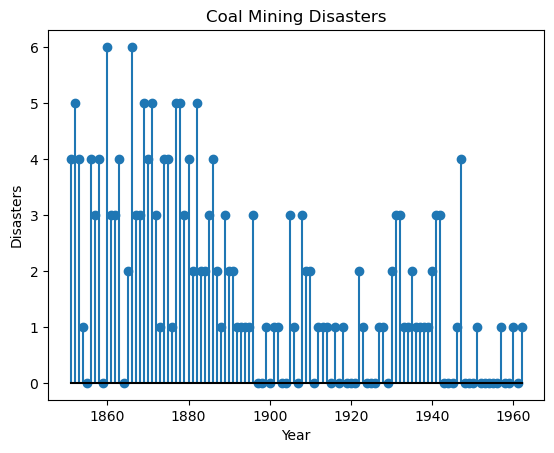

In [91]:
# Observed data
plt.stem(df_coal.index, df_coal["y"], basefmt='k-')
plt.title("Coal Mining Disasters")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.show()

In [92]:
# move intercept to 1851, so 1860 --> 1 and 1962 --> 111
years = np.arange(1, df_coal.shape[0] + 1)
years

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112])

### Step 2: Bayesian Poisson Regression

In [93]:
# Model Poisson Regression
with pm.Model(coords={"year": years}) as model5b:
    # data
    t = pm.ConstantData("t", years, dims="year")

    # prior
    beta0 = pm.Normal("beta0", mu=0, tau=0.001)
    beta1 = pm.Normal("beta1", mu=0, tau=0.001) 
    log_mu = beta0 + beta1 * t
    mu = pm.Deterministic("mu_t", pm.math.exp(log_mu), dims="year")

    # likelihood
    y = pm.Poisson("y", mu=mu, observed=df_coal["y"], dims="year")

    # sample
    trace5b = pm.sample(random_seed=42)
    trace5b = pm.sample_posterior_predictive(
        trace5b, extend_inferencedata=True, random_seed=42
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Sampling: [y]


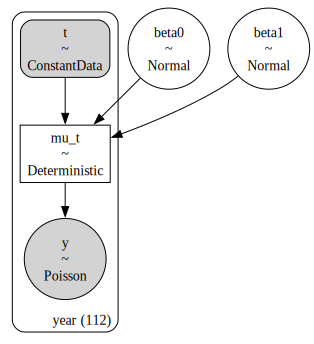

In [94]:
# Look causal graph
pm.model_to_graphviz(model5b)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


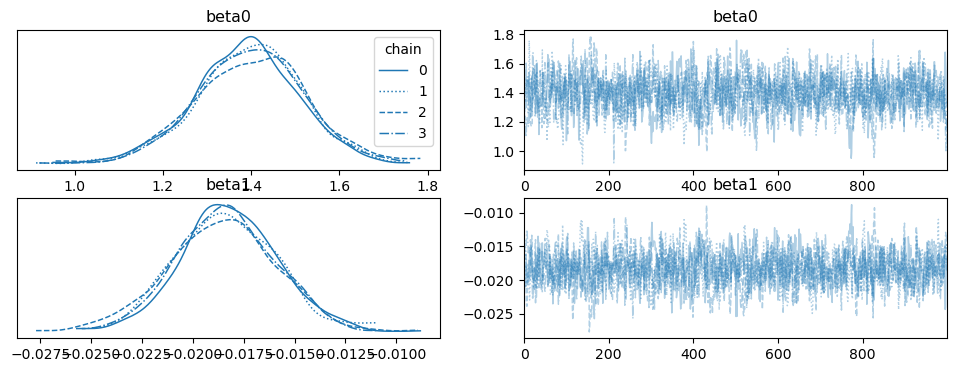

In [95]:
# Posterior predictive check
az.plot_trace(trace5b, var_names=["beta0", "beta1"], legend=True)
plt.show()

In [96]:
# Summary of the trace
az.summary(trace5b, hdi_prob=0.9, var_names=["beta0", "beta1"])

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0  1.395  0.121   1.177    1.581      0.004    0.003     873.0    1360.0   
beta1 -0.018  0.002  -0.022   -0.014      0.000    0.000    1000.0    1335.0   

       r_hat  
beta0    1.0  
beta1    1.0

In [97]:
# Summary of the exponantal of beta0 and beta1
az.summary(trace5b.map(np.exp), hdi_prob=0.9, var_names=["beta0", "beta1"])

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0  4.063  0.490   3.156    4.758      0.017    0.012     873.0    1360.0   
beta1  0.982  0.002   0.978    0.986      0.000    0.000    1000.0    1335.0   

       r_hat  
beta0    1.0  
beta1    1.0

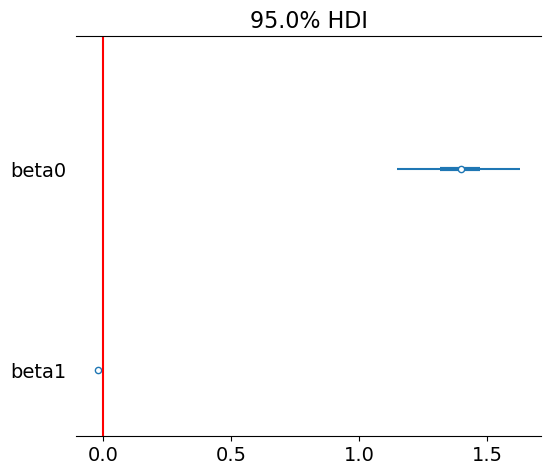

In [98]:
# Forest plot of the coefficients
az.plot_forest(trace5b, combined=True, hdi_prob=0.95, var_names=["beta0", "beta1"])

# draw vline at 0
plt.axvline(0, color='red')
plt.show()

The posterior distribution of the logit model states that the number of deaths is decreasing with time. It says that for each year the number of deaths decreases by $1-0.982=1.8\%$. However, the posterior predictive check states that there is uncertainty in the model.

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

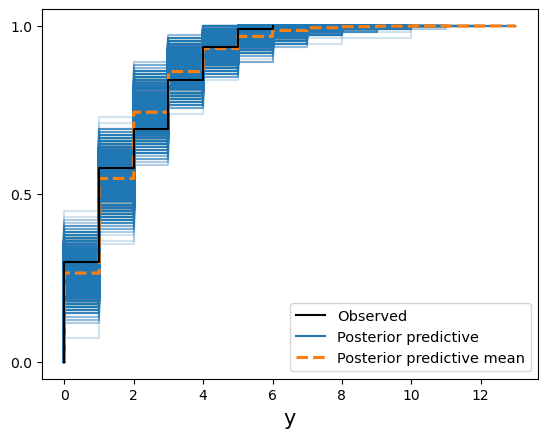

In [99]:
# Posterior predictive check of the dependent variable
az.plot_ppc(
    trace5b,
    kind='cumulative',
    data_pairs={"y": "y"}
)

In [100]:
# import sigmoid function
from scipy.special import expit

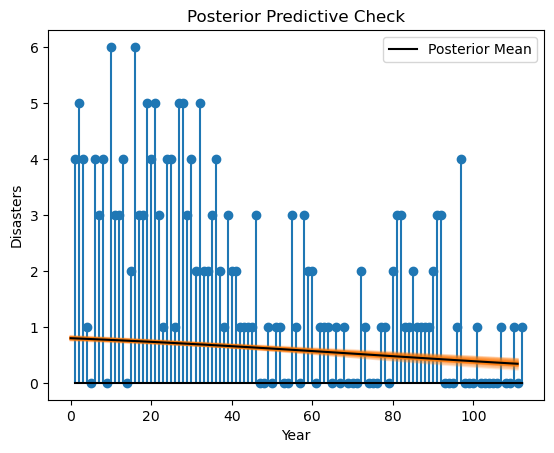

In [101]:
# Posterior distribution of the model
# show inference for each point
post = az.extract(trace5b, num_samples=100)
x_plot = xr.DataArray(years, dims=["year"])
lines = expit(post["beta0"] + post["beta1"] * x_plot)  # sigmoid

# plot
plt.stem(years, df_coal["y"], basefmt='k-')
plt.plot(np.arange(df_coal.shape[0]), lines.transpose(), alpha=0.1, color='C1')
plt.plot(np.arange(df_coal.shape[0]), lines.mean(dim="sample"), color='k', label="Posterior Mean")
plt.xlabel("Year")
plt.ylabel("Disasters")
plt.legend()
plt.title("Posterior Predictive Check")
plt.show()


Given the data, the model is not very informative. The majority of the predicted points are near to 0, as well the mean.

## Q5.C: Poisson Process with change point

For the same problem, now suppose there is a switchpoint $\tau$ in some year
$$
Y_{t}|\mu_{t} \sim \text{Poisson}(\mu_{t}), \\
\log(\mu_{t}) = \beta_{0} + \beta_{1} \mathbb{I}_{(t > \tau)}
$$

with $\beta_{0} \sim \mathcal{N}(0, \tau=0.001)$ and $\beta_{1} \sim \mathcal{N}(0, \tau=0.001) and $\tau \sim \text{Uniform}\{1,2, \dots, N\}$. Do a bayesian analysis

In [102]:
# Create Poisson Process with a change point
with pm.Model(coords={"year": years}) as model5c:
    # data
    t = pm.ConstantData("t", years, dims="year")

    # priors
    tau = pm.DiscreteUniform("tau", lower=years.min(), upper=years.max())  # tau ~ U(1, 112)
    beta0 = pm.Normal("beta0", mu=0, tau=0.001)
    beta1 = pm.Normal("beta1", mu=0, tau=0.001)
    log_mu = pm.math.switch(
        t >= tau, beta0 + beta1, beta0  # indicator function
    )
    mu = pm.Deterministic("mu_t", pm.math.exp(log_mu), dims="year")

    # likelihood
    y = pm.Poisson("y", mu=mu, observed=df_coal["y"], dims="year")

    # sample
    trace5c = pm.sample(10000, random_seed=42)  # more samples to get a better estimate
    trace5c = pm.sample_posterior_predictive(
        trace5c, extend_inferencedata=True, random_seed=42
    )


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [beta0, beta1]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 32 seconds.
Sampling: [y]


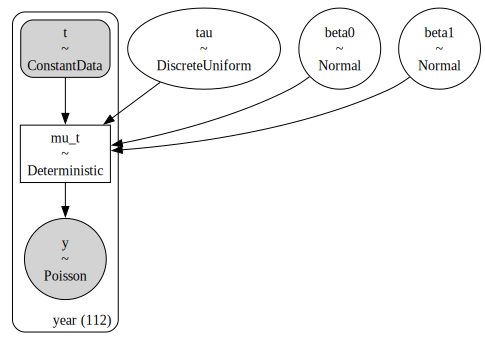

In [103]:
# Look causal graph
pm.model_to_graphviz(model5c)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


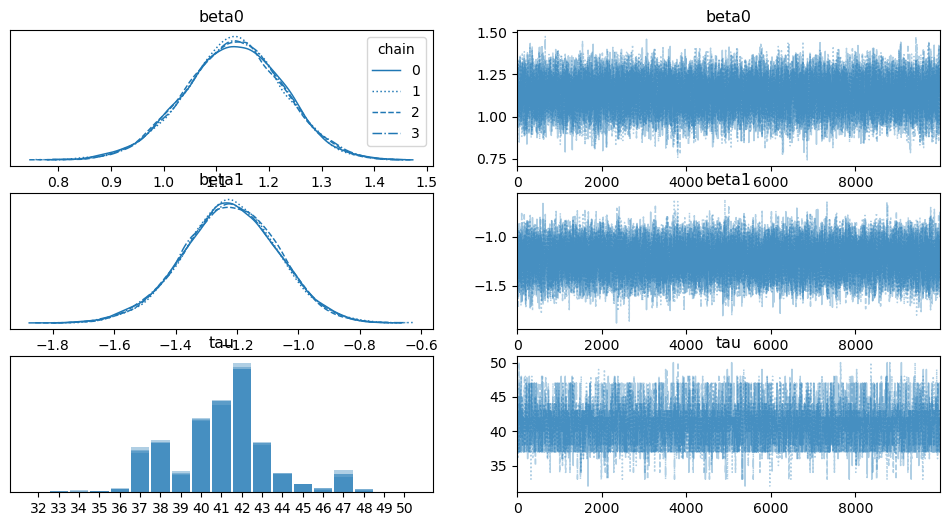

In [104]:
# Posterior predictive check for the model
az.plot_trace(trace5c, var_names=["beta0", "beta1", "tau"], legend=True)
plt.show()

In [105]:
# Summary of the trace
az.summary(trace5c, hdi_prob=0.9, var_names=["beta0", "beta1", "tau"])

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0   1.133  0.094   0.977    1.285      0.001    0.001   13513.0   19720.0   
beta1  -1.222  0.154  -1.473   -0.968      0.001    0.001   18023.0   22936.0   
tau    40.990  2.468  37.000   44.000      0.036    0.025    5078.0    5351.0   

       r_hat  
beta0    1.0  
beta1    1.0  
tau      1.0

In [106]:
# Summary of the exp trace
az.summary(trace5c.map(np.exp), hdi_prob=0.9, var_names=["beta0", "beta1", "tau"])

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/xarray/core/computation.py:825: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


mean            sd        hdi_5%       hdi_95%     mcse_mean  \
beta0  3.119000e+00  2.920000e-01  2.627000e+00  3.581000e+00  2.000000e-03   
beta1  2.980000e-01  4.600000e-02  2.220000e-01  3.710000e-01  0.000000e+00   
tau    2.054009e+19  1.546673e+20  1.171914e+16  1.285160e+19  1.785242e+18   

            mcse_sd  ess_bulk  ess_tail  r_hat  
beta0  2.000000e-03   13513.0   19720.0    1.0  
beta1  0.000000e+00   18023.0   22936.0    1.0  
tau    1.262405e+18    5078.0    5351.0    1.0

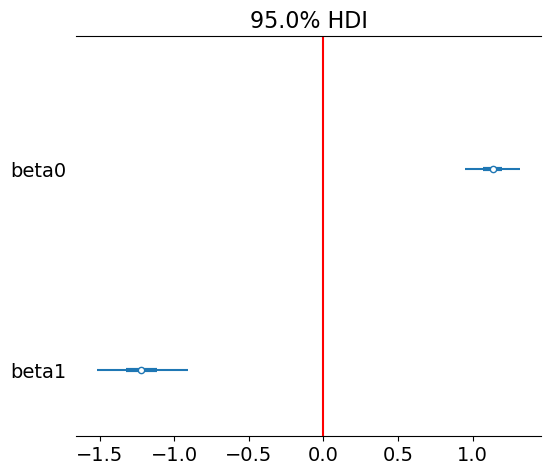

In [107]:
# Forest plot of the coefficients
az.plot_forest(trace5c, combined=True, hdi_prob=0.95, var_names=["beta0", "beta1"])

# draw vline at 0
plt.axvline(0, color='red')
plt.show()

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

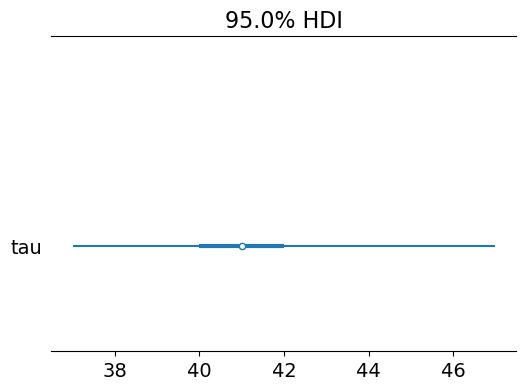

In [108]:
# Forest plot of the coefficients
az.plot_forest(trace5c, combined=True, hdi_prob=0.95, var_names=["tau"])

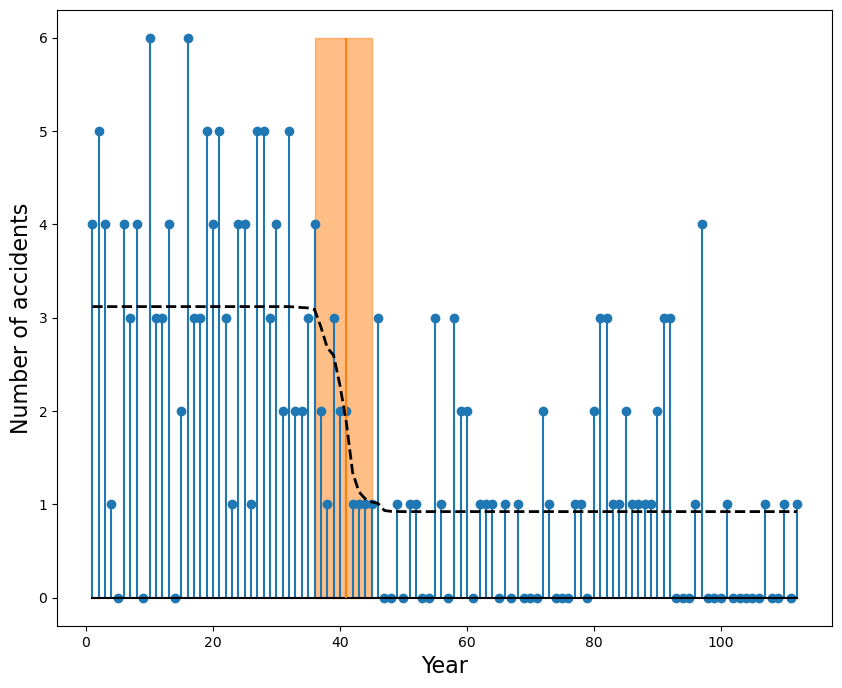

In [109]:
# Posterior distribution for the model
plt.figure(figsize=(10, 8))
plt.stem(years, df_coal["y"], basefmt='k-')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

# get the posterior mean of the predictions
trace = trace5c.posterior.stack(draws=("chain", "draw"))

# plot the posterior mean of the predictions
plt.vlines(trace["tau"].mean(), df_coal['y'].min(), df_coal['y'].max(), color="C1")
sp_hpd = az.hdi(trace5c, var_names=["tau"])["tau"].values
plt.fill_betweenx(
    y=[df_coal['y'].min(), df_coal['y'].max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)

# plot the posterior mean of the change point
average_disasters = np.zeros_like(df_coal['y'], dtype="float")
for i, year in enumerate(years):
    idx = year >= trace["tau"]
    average_disasters[i] = np.mean(np.where(idx, np.exp(trace["beta0"] + trace["beta1"]), np.exp(trace["beta0"])))
plt.plot(years, average_disasters, "k--", lw=2)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

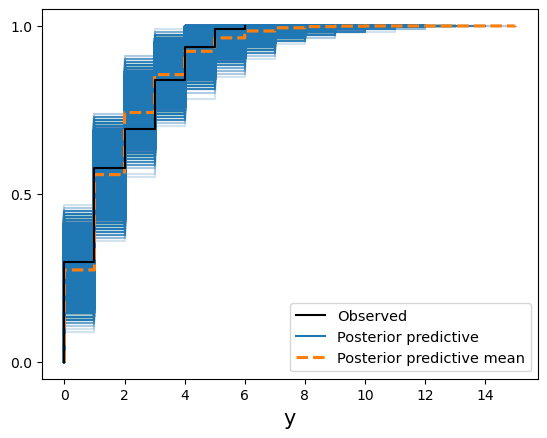

In [110]:
# Posterior predictive check of the dependent variable
az.plot_ppc(
    trace5c,
    kind='cumulative',
    data_pairs={"y": "y"}
)

This model captures far better the observed data and also is able to explain the difference between one era from another.

- First of all, the model finds that there is a changepoint between the year 37 and 44, i.e. between 1888 and 1895.

- Secondly, it states that from era 1 to era 2 the number of deaths decreases by $1-0.298=70.2\%$, in average. This is a huge decrease in the number of deaths.

- The posterior predictive check looks more sound than the previous model. The model is able to predict the data with a high degree of certainty.